In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


In [8]:
# -----------------------------------------
# Step 1: Generate the RT-Based Gaussian Envelope (Global Intensity)
# -----------------------------------------
def generate_rt_gaussian(rt_values, mu=15, sigma=5, amplitude=100):
    """
    Generates a global intensity modulation function along the RT axis.
    
    Parameters:
        rt_values (array): RT values (time points)
        mu (float): Center of the RT Gaussian
        sigma (float): Spread of the RT Gaussian
        amplitude (float): Peak intensity value
    
    Returns:
        np.array: Intensity modulation values for each RT
    """
    return amplitude * np.exp(-((rt_values - mu) ** 2) / (2 * sigma ** 2))


In [9]:
# -----------------------------------------
# Step 2: Generate Vertical m/z Gaussians
# -----------------------------------------
def generate_gaussian_mz(num_mz_points=30, mz_range=(50, 150), mu=100, sigma=15, amplitude=100):
    """
    Generates a Gaussian peak along the m/z (Y-axis), spaced evenly, mimicking binned data.

    Parameters:
        num_mz_points (int): Number of m/z values to generate.
        mz_range (tuple): Range of m/z values.
        mu (float): Center of the Gaussian along the m/z axis.
        sigma (float): Spread of the peak.
        amplitude (float): Maximum intensity.

    Returns:
        tuple: (valid_mz_values, valid_intensity_values)
    """
    # Generate evenly spaced m/z values
    mz_values = np.linspace(mz_range[0], mz_range[1], num_mz_points)

    # Apply binning: Remove every second value
    mz_values_binned = mz_values.copy()
    mz_values_binned[1::2] = np.nan  # Simulate binning by setting NaN values

    # Compute Gaussian intensity values
    intensity_values = amplitude * np.exp(-((mz_values_binned - mu) ** 2) / (2 * sigma ** 2))

    # Remove NaN values to return only valid data points
    valid_mz_values = mz_values_binned[~np.isnan(mz_values_binned)]
    valid_intensity_values = intensity_values[~np.isnan(mz_values_binned)]

    return valid_mz_values, valid_intensity_values

In [10]:
# -----------------------------------------
# Step 3: Randomize Gaussian Position in m/z
# -----------------------------------------
def generate_random_mu(mz_range=(50, 150), shift_range=(-5, 5)):
    """
    Generates a random 'mu' (the center of the Gaussian) within a specified shift range.

    Parameters:
        mz_range (tuple): Range of m/z values (min, max).
        shift_range (tuple): Range within which to randomly shift the Gaussian mean (mu).

    Returns:
        float: Randomized mu value.
    """
    # Generate random shift
    shift = np.random.uniform(shift_range[0], shift_range[1])
    random_mu = np.mean(mz_range) + shift  # Centered around the middle of mz_range

    # Ensure the new mu is within the m/z bounds
    return np.clip(random_mu, mz_range[0], mz_range[1])


# -----------------------------------------
# Step 4: Generate 2D Gaussian Peaks Over RT and m/z
# -----------------------------------------
def generate_gaussian_peaks(num_rt_points=15, rt_range=(0, 30), mz_range=(50, 150),
                            rt_mu=15, rt_sigma=5, rt_amplitude=100, shift_range=(-5, 5),
                            **gaussian_params):
    """
    Generates a set of m/z Gaussian peaks across different RT values, influenced by a global RT Gaussian.
    
    Parameters:
        num_rt_points (int): Number of RT values to generate
        rt_range (tuple): Range of RT values
        mz_range (tuple): Range of m/z values
        rt_mu, rt_sigma, rt_amplitude: Parameters for the RT Gaussian (Global Intensity)
        shift_range (tuple): Range for shifting m/z Gaussian centers
        **gaussian_params: Parameters for individual m/z Gaussian peaks
    
    Returns:
        pd.DataFrame: DataFrame with RT values, m/z values, and intensity values.
    """
    # Initialize an empty list to store DataFrame rows
    data = []
    
    # Generate RT values (evenly spaced by 2, every 2nd value)
    rt_values = np.arange(rt_range[0], rt_range[1], 2)  # Generate RT values every 2nd value
    
    # Generate RT intensity envelope (global 2D shape)
    rt_intensity_modulation = generate_rt_gaussian(rt_values, mu=rt_mu, sigma=rt_sigma, amplitude=rt_amplitude)

    for rt, rt_intensity in zip(rt_values, rt_intensity_modulation):
        # Randomize mu for vertical m/z Gaussian at this RT
        random_mu = generate_random_mu(mz_range=mz_range, shift_range=shift_range)
        gaussian_params['mu'] = random_mu

        # Generate m/z values and base intensity
        mz_values, intensity_values = generate_gaussian_mz(**gaussian_params)
        
        # Scale intensity values based on RT intensity
        scaled_intensity = intensity_values * (rt_intensity / rt_amplitude)  # Normalize scaling
        
        # Append data
        data.append([rt, mz_values.tolist(), scaled_intensity.tolist()])
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['RT', 'm/z values', 'Intensity values'])
    print(df)
    return df



In [11]:
# -----------------------------------------
# Step 5: Plot the Generated Gaussian Peaks
# -----------------------------------------
def plot_gaussian_peaks(df):
    """
    Plots the Gaussian peaks stored in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing RT, m/z values, and intensity values.
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    for _, row in df.iterrows():
        rt_value = row['RT']
        mz_values = np.array(row['m/z values'])
        intensity_values = np.array(row['Intensity values'])

        # Normalize intensities for colormap
        norm = plt.Normalize(vmin=np.nanmin(df['Intensity values'].explode()), 
                             vmax=np.nanmax(df['Intensity values'].explode()))
        cmap = cm.plasma_r  # Colormap
        colors = cmap(norm(intensity_values))

        # Plot vertical bars for each RT value
        ax.barh(mz_values, [1] * len(mz_values), left=rt_value, height=2, color=colors, edgecolor='black')

    # Labels and limits
    ax.set_xlabel("RT")
    ax.set_ylabel("m/z")
    ax.set_title("2D Gaussian Peaks (RT & m/z)")

    # Create colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Intensity")

    plt.show()


    RT                                         m/z values  \
0    0  [50.0, 56.89655172413793, 63.79310344827586, 7...   
1    2  [50.0, 56.89655172413793, 63.79310344827586, 7...   
2    4  [50.0, 56.89655172413793, 63.79310344827586, 7...   
3    6  [50.0, 56.89655172413793, 63.79310344827586, 7...   
4    8  [50.0, 56.89655172413793, 63.79310344827586, 7...   
5   10  [50.0, 56.89655172413793, 63.79310344827586, 7...   
6   12  [50.0, 56.89655172413793, 63.79310344827586, 7...   
7   14  [50.0, 56.89655172413793, 63.79310344827586, 7...   
8   16  [50.0, 56.89655172413793, 63.79310344827586, 7...   
9   18  [50.0, 56.89655172413793, 63.79310344827586, 7...   
10  20  [50.0, 56.89655172413793, 63.79310344827586, 7...   
11  22  [50.0, 56.89655172413793, 63.79310344827586, 7...   
12  24  [50.0, 56.89655172413793, 63.79310344827586, 7...   
13  26  [50.0, 56.89655172413793, 63.79310344827586, 7...   
14  28  [50.0, 56.89655172413793, 63.79310344827586, 7...   
15  30  [50.0, 56.896551

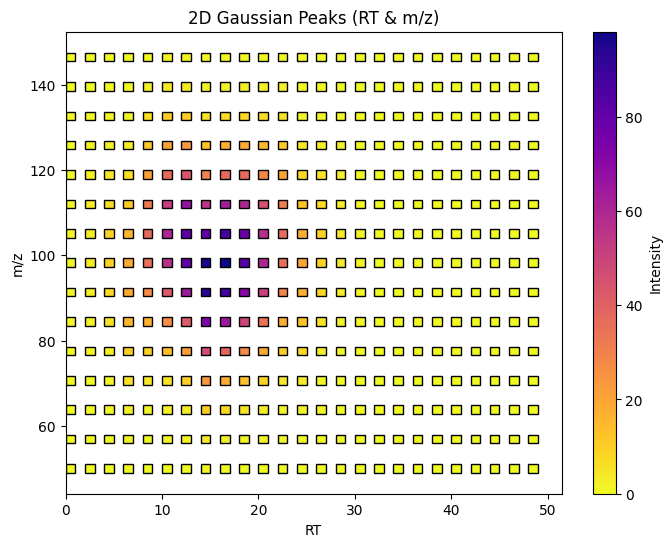

In [12]:
# -----------------------------------------
# Step 6: Generate Data and Plot
# -----------------------------------------
gaussian_params = {
    'num_mz_points': 30,
    'sigma': 15,
    'amplitude': 100
}

df_2D_gaussian = generate_gaussian_peaks(num_rt_points=30, rt_range=(0, 50), mz_range=(50, 150),
                                         rt_mu=15, rt_sigma=5, rt_amplitude=100, shift_range=(-5, 5),
                                         **gaussian_params)

plot_gaussian_peaks(df_2D_gaussian)